In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
conn = psycopg2.connect(database='hackathon2020_dev', user="postgres", password="Allo123!", host="127.0.0.1", port="5432")

df = pd.read_sql_query("SELECT * FROM public.trump_tweets",con=conn,index_col=['id'])
df.head()

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index
id,,,,,,,,,,,,
52952,342312442300354561,https://twitter.com/realDonaldTrump/status/342...,Giving away money and revolutionizing crowdfun...,2013-06-05 11:10:20,32,18,@fundanything,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
52953,342313853767532545,https://twitter.com/realDonaldTrump/status/342...,@ tfore4 Our clubhouse on the North Sea. http:...,2013-06-05 11:15:57,4,1,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
52954,342320095332294657,https://twitter.com/realDonaldTrump/status/342...,@ Judare So true!,2013-06-05 11:40:45,3,0,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
52955,342321095636049920,https://twitter.com/realDonaldTrump/status/342...,A-Rod has disgraced the blessed @ Yankees orga...,2013-06-05 11:44:43,665,386,@Yankees,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
52956,342341507421990913,https://twitter.com/realDonaldTrump/status/342...,"Kern County, CA has secured $1.2B for windfarm...",2013-06-05 13:05:50,48,16,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None


In [3]:
airline_df = pd.read_csv("../db/Tweets.csv")
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
airline_review_df = airline_df[['text','airline_sentiment']]

airline_review_df = airline_review_df[airline_review_df['airline_sentiment'] != 'neutral']
airline_review_df.head(5)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [5]:
print(airline_review_df["airline_sentiment"].value_counts())

sentiment_label = airline_review_df.airline_sentiment.factorize()
print(sentiment_label)

tweet = airline_review_df.text.values
print(tweet)

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64
(array([0, 1, 1, ..., 0, 1, 1]), Index(['positive', 'negative'], dtype='object'))
["@VirginAmerica plus you've added commercials to the experience... tacky."
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it" ...
 '@AmericanAir thank you we got on a different flight to Chicago.'
 "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc"
 "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"]


In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [7]:
# Try using a long short-term memory net

vocab_size = 10000
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 336,651
Trainable params: 336,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 34s 111ms/step - loss: 0.3917 - accuracy: 0.8374 - val_loss: 0.2304 - val_accuracy: 0.9233
Epoch 2/5
289/289 [==============================] - 54s 186ms/step - loss: 0.2251 - accuracy: 0.9132 - val_loss: 0.1687 - val_accuracy: 0.9428
Epoch 3/5
289/289 [==============================] - 36s 124ms/step - loss: 0.1597 - accuracy: 0.9386 - val_loss: 0.1629 - val_accuracy: 0.9389
Epoch 4/5
289/289 [==============================] - 47s 162ms/step - loss: 0.1363 - accuracy: 0.9485 - val_loss: 0.1875 - val_accuracy: 0.9437
Epoch 5/5
289/289 [==============================] - 49s 169ms/step - loss: 0.1100 - accuracy: 0.9581 - val_loss: 0.1859 - val_accuracy: 0.9376


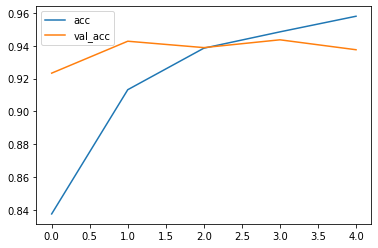

In [9]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

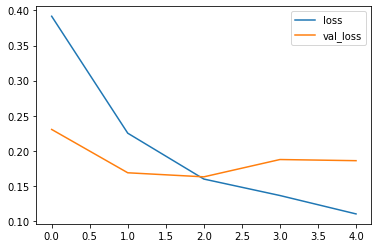

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [11]:
def predict_sentiment(text, model_for_prediction):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=200)
    return int(model_for_prediction.predict(tw).round().item())

In [12]:
model.save('../notebooks/sentiment_predictor')

INFO:tensorflow:Assets written to: ../notebooks/sentiment_predictor/assets


In [13]:
model = load_model('../notebooks/sentiment_predictor')

In [14]:
predict_sentiment('fucking morons', model)

1

In [15]:
df['sentiment'] = None

def analyze_tweets(target_df, model):
    return [predict_sentiment(x, model) for x in df['content'].array]

#df['sentiment'] = analyze_tweets(df, model)

In [16]:
df.head(5)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index
id,,,,,,,,,,,,
52952,342312442300354561,https://twitter.com/realDonaldTrump/status/342...,Giving away money and revolutionizing crowdfun...,2013-06-05 11:10:20,32,18,@fundanything,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None,None
52953,342313853767532545,https://twitter.com/realDonaldTrump/status/342...,@ tfore4 Our clubhouse on the North Sea. http:...,2013-06-05 11:15:57,4,1,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None,None
52954,342320095332294657,https://twitter.com/realDonaldTrump/status/342...,@ Judare So true!,2013-06-05 11:40:45,3,0,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None,None
52955,342321095636049920,https://twitter.com/realDonaldTrump/status/342...,A-Rod has disgraced the blessed @ Yankees orga...,2013-06-05 11:44:43,665,386,@Yankees,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None,None
52956,342341507421990913,https://twitter.com/realDonaldTrump/status/342...,"Kern County, CA has secured $1.2B for windfarm...",2013-06-05 13:05:50,48,16,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None,None


In [17]:
content_array = df['content'].array
df['sentiment'] = [predict_sentiment(x, model) for x in content_array]

In [18]:
df.head(5)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index
id,,,,,,,,,,,,
52952,342312442300354561,https://twitter.com/realDonaldTrump/status/342...,Giving away money and revolutionizing crowdfun...,2013-06-05 11:10:20,32,18,@fundanything,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
52953,342313853767532545,https://twitter.com/realDonaldTrump/status/342...,@ tfore4 Our clubhouse on the North Sea. http:...,2013-06-05 11:15:57,4,1,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
52954,342320095332294657,https://twitter.com/realDonaldTrump/status/342...,@ Judare So true!,2013-06-05 11:40:45,3,0,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
52955,342321095636049920,https://twitter.com/realDonaldTrump/status/342...,A-Rod has disgraced the blessed @ Yankees orga...,2013-06-05 11:44:43,665,386,@Yankees,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
52956,342341507421990913,https://twitter.com/realDonaldTrump/status/342...,"Kern County, CA has secured $1.2B for windfarm...",2013-06-05 13:05:50,48,16,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None


In [19]:
sentiments = df['sentiment'].array
ids = df['tweetId'].array

update_array = list(zip(ids, sentiments))

update_sql = ['update public.trump_tweets set "sentiment" = {} where "tweetId" = {};'.format(row[1], row[0]) for row in update_array]
print(len(update_sql))

43297


In [20]:
with open('../db/update_data/update_sentiment.sql', 'w') as output:
    output.write('\n'.join(update_sql))

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk

In [27]:
top_N = 10

nltk.download('popular')

txt = df.content.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to /home/jean-
[nltk_data]    |     francois/nltk_data...
[nltk_dat

In [28]:
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

In [29]:
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

All frequencies, including STOPWORDS:
  Word  Frequency
0    @      42084
1    .      37345
2  the      34517
3    ,      30057
4    !      27579
5    :      21719
6   to      19762
7  and      15820
8    a      14875
9   ``      14094


<AxesSubplot:xlabel='Word'>

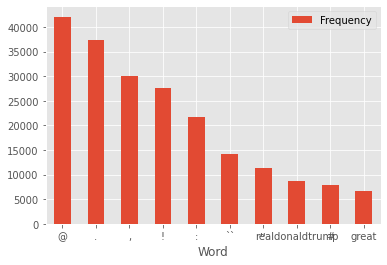

In [30]:
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')

rslt.plot.bar(rot=0)

In [43]:
df_sorted = df.sort_values(by='retweets', ascending=False)
df_sorted.head(n=100)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index
id,,,,,,,,,,,,
75311,881503147168071680,https://twitter.com/realDonaldTrump/status/881...,# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg,2017-07-02 08:21:42,302269,515729,None,#FNNpic,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
74174,795954831718498305,https://twitter.com/realDonaldTrump/status/795...,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 05:43:14,289872,508758,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
58851,474134260149157888,https://twitter.com/realDonaldTrump/status/474...,Are you allowed to impeach a president for gro...,2014-06-04 05:23:11,242667,235119,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
81871,1157345692517634049,https://twitter.com/realDonaldTrump/status/115...,A$AP Rocky released from prison and on his way...,2019-08-02 12:41:30,232085,835575,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
86272,1267129644228247552,https://twitter.com/realDonaldTrump/status/126...,The United States of America will be designati...,2020-05-31 11:23:43,224890,828937,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...
85175,1239205277381132290,https://twitter.com/realDonaldTrump/status/123...,TODAY IS A NATIONAL DAY OF PRAYER. GOD BLESS E...,2020-03-15 10:02:16,72973,399249,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
78752,1045444544068812800,https://twitter.com/realDonaldTrump/status/104...,Judge Kavanaugh showed America exactly why I n...,2018-09-27 17:46:17,72926,291464,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
86560,1271780462202179592,https://twitter.com/realDonaldTrump/status/127...,MAKE AMERICA GREAT AGAIN!,2020-06-13 07:24:25,72762,472497,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None
